In [3]:
from pathlib import Path
from act_pol.analysis.files import process_sim
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, ks_2samp, maxwell, kstest, norm
from utils import plot
from utils.plot import cm
from matplotlib.lines import Line2D
np.random.seed(seed=42)

In [10]:
class Simulation:
    """A class to process simulation data."""

    def __init__(self, *, B, F, D, L, b=1, directory="simulations", unitful=False):
        self.path = Path(f"./{directory}/B{B:.3g}_F{F:.3g}_D{D:.3g}_L{L:.3g}/")
        print(self.path)
        self.files = list(self.path.glob("tape*.csv"))
        
        # Define unitful length scale
        self.Lk = 35.36  # Kuhn length in nm

        # Load enhancer and promoter positions
        data = np.genfromtxt(self.files[0], delimiter=',', skip_header=1)
        self.s1 = int(data[0, -1])
        self.s2 = int(data[0, -2])
        
        # Get simulation parameters
        self.N = self.s1-self.s2
        self.b = 1
        self.Lep = (self.N)*self.b
        self.Lp = self.b/2
        self.R = 250/self.Lk
        
        if unitful:
            conversion = self.Lk
            self.b = self.b*self.Lk
            self.Lep = self.Lep*self.Lk
            self.Lp = self.Lp*self.Lk
            self.R = self.R*self.Lk
        else:
            conversion = 1
            

        # Compute displacement
        self.displacement = np.squeeze(
            np.vstack([
                np.diff(process_sim(file)[0][:, [self.s1, self.s2], :], axis=1)
                for file in self.files
            ])
        )
        # Convert length data to unitful quantities if unitful=True
        self.displacement = self.displacement*conversion

        # Generate Gaussian KDEs for displacement
        self.displacement_g = [
            gaussian_kde(self.displacement[:, i]) 
            for i in range(self.displacement.shape[1])
        ]

        # Compute 1D Gaussians of variance Nb^2/3
        gaussian_1D_prefactor = (3/(2*np.pi*self.N*self.b**2))**(1/2)
        self.gaussian_1D = lambda r: gaussian_1D_prefactor*np.exp(-3/(2*self.N*self.b**2)*r**2)
        self.gaussian_1D_rv = norm(scale=np.sqrt(self.N*self.b**2/3))
        
        # Compute distance and its Gaussian KDE
        # If unitful=True, there's no need to convert again since we use displacement data
        self.distance = np.linalg.norm(self.displacement, axis=1)
        self.distance_g = gaussian_kde(self.distance)
        
        # Compute maxwell distribution
        maxwell_prefactor = 4*np.pi*(3/(4*self.Lep*self.Lp)/np.pi)**(3/2)
        self.maxwell = lambda r: maxwell_prefactor*r**2*np.exp(-3/(4*self.Lep*self.Lp)*(r**2))
        self.maxwell_rv = maxwell(scale=np.sqrt(2*self.Lep*self.Lp/3))

def hist(ax,arr,density=True,fill=False,histtype='step',linewidth=1.5,**kwargs):
    """Plot a histogram with pre-defined kwargs."""
    
    ax.hist(arr,density=density,fill=fill,histtype=histtype,linewidth=linewidth,**kwargs)

def histlegend(ax,**kwargs):
    """Convert step legend handles to lines."""
    
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [
        h if isinstance(h, Line2D) else Line2D([], [], c=h.get_edgecolor())
        for h in handles
    ]
    ax.legend(handles=new_handles, labels=labels,**kwargs)

In [11]:
"""Equilibrium distribution with no perturbation."""
sim = Simulation(B=0,F=1,D=1,L=150,directory="old_simulations")

old_simulations/B0_F1_D1_L150


Text(0.5, 1.0, '$\\beta=0,\\xi=1,A=1$')

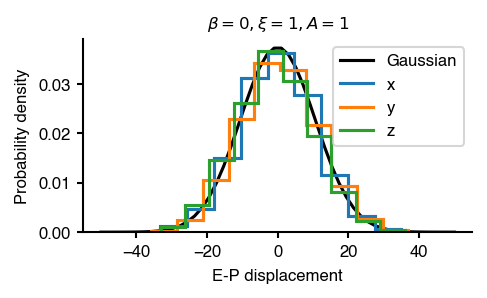

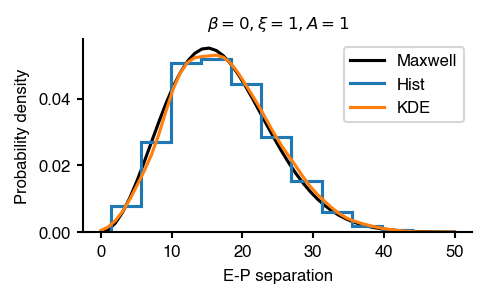

In [12]:
fig, ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P displacement")
r = np.linspace(-50,50)
ax.plot(r,sim.gaussian_1D_rv.pdf(r),label="Gaussian",color="black")
hist(ax,sim.displacement[:,0],label="x")
hist(ax,sim.displacement[:,1],label="y")
hist(ax,sim.displacement[:,2],label="z")
histlegend(ax)
ax.set_title(r"$\beta=0,\xi=1,A=1$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,sim.maxwell(r),label="Maxwell",color="black")
hist(ax,sim.distance,label="Hist")
ax.plot(r,sim.distance_g(r),label="KDE")
# ax.plot(r,sim.maxwell_rv.pdf(r),label="Maxwell (Scipy)")
histlegend(ax)
ax.set_title(r"$\beta=0,\xi=1,A=1$")

In [7]:
import numpy as np
for i in np.arange(0,20+2.5,2.5):
    for j in np.arange(10, 210, 20):
        print(f"python flow_sim.py ${{SLURM_ARRAY_JOB_ID}}_${{SLURM_ARRAY_TASK_ID}} {i:.3g} 14 1/14 {j:.3g}")

In [8]:
ks_2samp(sim.maxwell_rv.rvs(sim.distance.size),sim.distance).pvalue

0.32565532504945294

In [13]:
"""Increase friction and decrease diffusivity by the same factor."""
perturb_FD = [Simulation(B=0,F=n,D=1/n,L=150,directory="old_simulations") for n in [25, 50, 100]]

old_simulations/B0_F25_D0.04_L150
old_simulations/B0_F50_D0.02_L150
old_simulations/B0_F100_D0.01_L150


Text(0.5, 1.0, '$\\beta=0$')

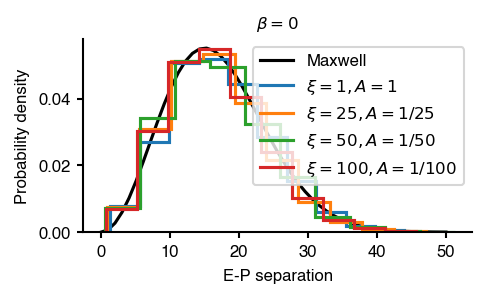

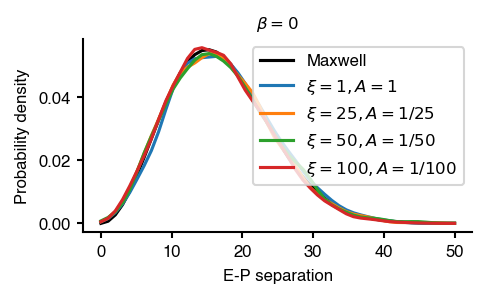

In [24]:
ps = [ks_2samp(sim.maxwell_rv.rvs(sim.distance.size), x.distance).pvalue for x in perturb_FD]

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,sim.maxwell(r),label="Maxwell",color="black")
hist(ax,sim.distance,label=r"$\xi=1,A=1$")
hist(ax,perturb_FD[0].distance,label=r"$\xi=25,A=1/25$")
hist(ax,perturb_FD[1].distance,label=r"$\xi=50,A=1/50$")
hist(ax,perturb_FD[2].distance,label=r"$\xi=100,A=1/100$")
histlegend(ax)
ax.set_title(r"$\beta=0$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,sim.maxwell(r),label="Maxwell",color="black")
ax.plot(r,sim.distance_g(r),label=r"$\xi=1,A=1$")
ax.plot(r,perturb_FD[0].distance_g(r),label=r"$\xi=25,A=1/25$")
ax.plot(r,perturb_FD[1].distance_g(r),label=r"$\xi=50,A=1/50$")
ax.plot(r,perturb_FD[2].distance_g(r),label=r"$\xi=100,A=1/100$")
histlegend(ax)
ax.set_title(r"$\beta=0$")

In [15]:
"""Increase flow only."""
perturb_B = {n: Simulation(B=n,F=1,D=1,L=150,directory="old_simulations") for n in [0.01, 0.1, 1, 10, 12.5, 15, 17.5, 20, 25, 50, 100]}

old_simulations/B0.01_F1_D1_L150
old_simulations/B0.1_F1_D1_L150
old_simulations/B1_F1_D1_L150
old_simulations/B10_F1_D1_L150
old_simulations/B12.5_F1_D1_L150
old_simulations/B15_F1_D1_L150
old_simulations/B17.5_F1_D1_L150
old_simulations/B20_F1_D1_L150
old_simulations/B25_F1_D1_L150
old_simulations/B50_F1_D1_L150
old_simulations/B100_F1_D1_L150


Text(0.5, 1.0, '$\\xi=1,A=1$')

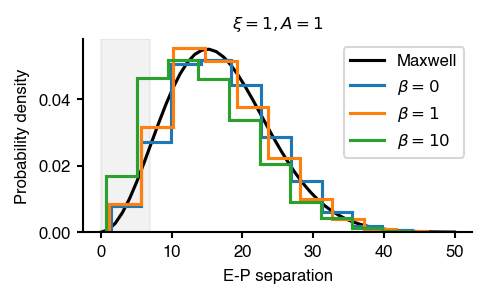

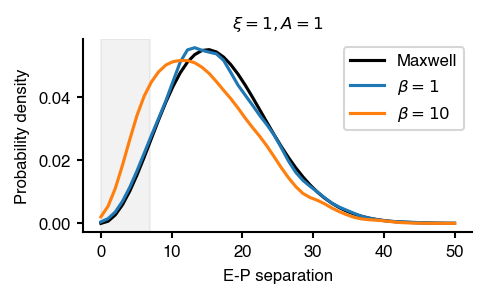

In [23]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,sim.maxwell(r),label="Maxwell",color="black")
hist(ax,sim.distance,label=r"$\beta=0$")
hist(ax,perturb_B[1].distance,label=r"$\beta=1$")
hist(ax,perturb_B[10].distance,label=r"$\beta=10$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\xi=1,A=1$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,sim.maxwell(r),label="Maxwell",color="black")
ax.plot(r, perturb_B[1].distance_g(r),label=r"$\beta=1$")
ax.plot(r, perturb_B[10].distance_g(r),label=r"$\beta=10$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\xi=1,A=1$")

Text(0.5, 1.0, '$\\xi=1,A=1$')

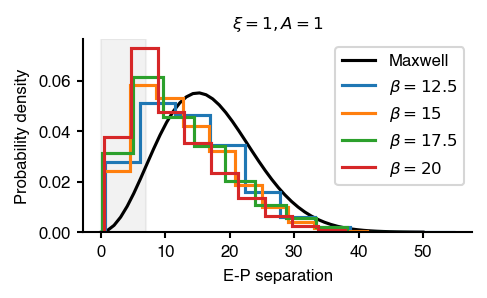

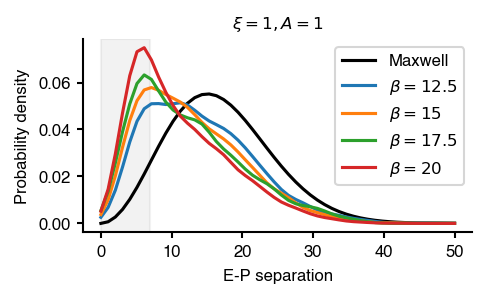

In [22]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,sim.maxwell(r),label="Maxwell",color="black")
hist(ax,perturb_B[12.5].distance,label=r"$\beta=12.5$")
hist(ax,perturb_B[15].distance,label=r"$\beta=15$")
hist(ax,perturb_B[17.5].distance,label=r"$\beta=17.5$")
hist(ax,perturb_B[20].distance,label=r"$\beta=20$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\xi=1,A=1$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,sim.maxwell(r),label="Maxwell",color="black")
ax.plot(r, perturb_B[12.5].distance_g(r),label=r"$\beta=12.5$")
ax.plot(r, perturb_B[15].distance_g(r),label=r"$\beta=15$")
ax.plot(r, perturb_B[17.5].distance_g(r),label=r"$\beta=17.5$")
ax.plot(r, perturb_B[20].distance_g(r),label=r"$\beta=20$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\xi=1,A=1$")

Text(0.5, 1.0, '$\\xi=1,A=1$')

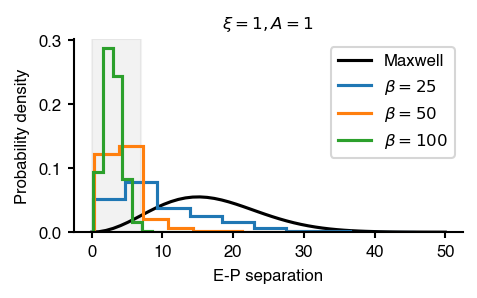

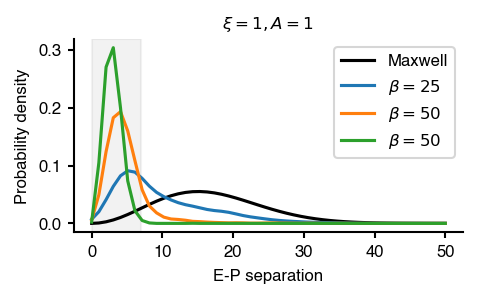

In [21]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,sim.maxwell(r),label="Maxwell",color="black")
hist(ax,perturb_B[25].distance,label=r"$\beta=25$")
hist(ax,perturb_B[50].distance,label=r"$\beta=50$")
hist(ax,perturb_B[100].distance,label=r"$\beta=100$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\xi=1,A=1$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,sim.maxwell(r),label="Maxwell",color="black")
ax.plot(r,perturb_B[25].distance_g(r),label=r"$\beta=25$")
ax.plot(r,perturb_B[50].distance_g(r),label=r"$\beta=50$")
ax.plot(r,perturb_B[100].distance_g(r),label=r"$\beta=50$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\xi=1,A=1$")

In [19]:
"""Decrease diffusivity only."""
perturb_D = [Simulation(B=0,F=1,D=n,L=150,directory="old_simulations") for n in [1/25, 1/50, 1/100, 0]]

old_simulations/B0_F1_D0.04_L150
old_simulations/B0_F1_D0.02_L150
old_simulations/B0_F1_D0.01_L150
old_simulations/B0_F1_D0_L150


Text(0.5, 1.0, '$\\beta=0,\\xi=1$')

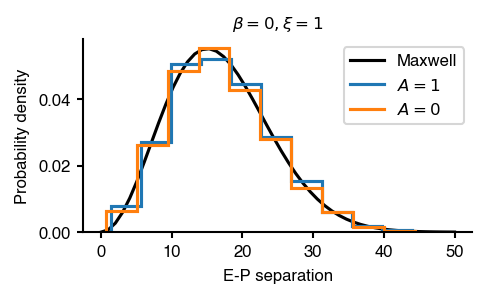

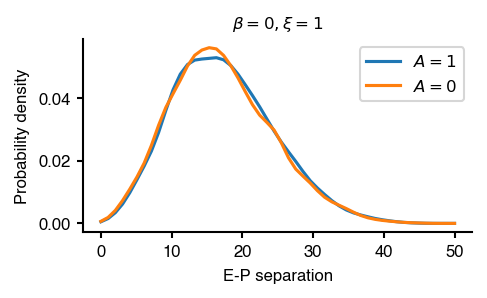

In [26]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
ax.plot(r,sim.maxwell(r),label="Maxwell",color="black")
hist(ax,sim.distance,label=r"$A=1$")
hist(ax,perturb_D[3].distance,label=r"$A=0$")
histlegend(ax)
ax.set_title(r"$\beta=0,\xi=1$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
ax.plot(r,sim.distance_g(r),label="$A=1$")
ax.plot(r,perturb_D[3].distance_g(r),label=r"$A=0$",color=plt.colormaps["tab10"](1))
ax.legend()
ax.set_title(r"$\beta=0,\xi=1$")

In [28]:
"""Increase friction only."""
perturb_F = [Simulation(B=0,F=n,D=1,L=150,directory="old_simulations") for n in [25, 50, 100]]

old_simulations/B0_F25_D1_L150
old_simulations/B0_F50_D1_L150
old_simulations/B0_F100_D1_L150


NameError: name 'perturb_F' is not defined

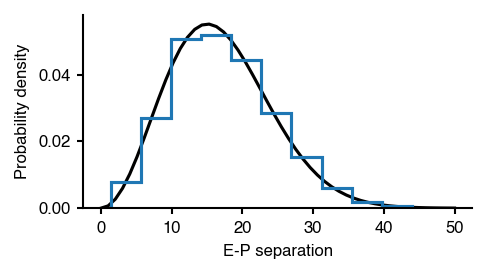

In [27]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
ax.plot(r,sim.maxwell(r),label="Maxwell",color="black")
hist(ax,sim.distance,label=r"$\xi=1$")
hist(ax,perturb_F[-1].distance,label=r"$\xi=100$")
histlegend(ax)
ax.set_title(r"$\beta=0,A=1$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
ax.plot(r,sim.maxwell(r),label="Maxwell",color="black")
ax.plot(r,perturb_F[-1].distance_g(r),label=r"$\xi=100$",color=plt.colormaps["tab10"](1))
ax.legend()
ax.set_title(r"$\beta=0,A=1$")

In [ ]:
"""Finite flow increase friction and decrease diffusivity by the same factor."""
perturb_FD_B10 = [Simulation(B=10,F=n,D=1/n,L=150,directory="old_simulations") for n in [25, 50, 100]]
perturb_FD_B25 = [Simulation(B=25,F=n,D=1/n,L=150,directory="old_simulations") for n in [25, 50, 100]]

simulations/B10_F25_D0.04_L150
simulations/B10_F49_D0.0204_L150
simulations/B10_F100_D0.01_L150
simulations/B25_F25_D0.04_L150
simulations/B25_F49_D0.0204_L150
simulations/B25_F100_D0.01_L150


Text(0.5, 1.0, '$\\beta=10,\\xi=x^2, D=1/x^2$')

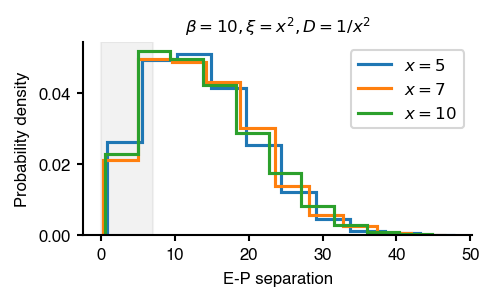

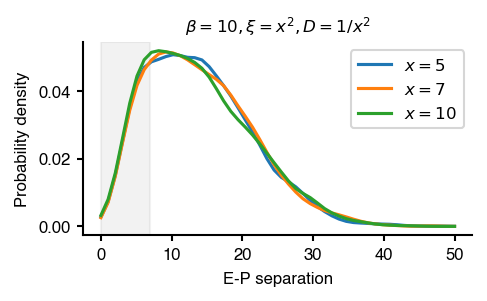

In [ ]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
hist(ax,perturb_FD_B10[0].distance,label=r"$x=5$")
hist(ax,perturb_FD_B10[1].distance,label=r"$x=7$")
hist(ax,perturb_FD_B10[2].distance,label=r"$x=10$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\beta=10,\xi=x, D=1/x$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,perturb_FD_B10[0].distance_g(r),label=r"$x=5$")
ax.plot(r,perturb_FD_B10[1].distance_g(r),label=r"$x=7$")
ax.plot(r,perturb_FD_B10[2].distance_g(r),label=r"$x=10$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\beta=10,\xi=x, D=1/x$")

Text(0.5, 1.0, '$\\beta=25,\\xi=x^2, D=1/x^2$')

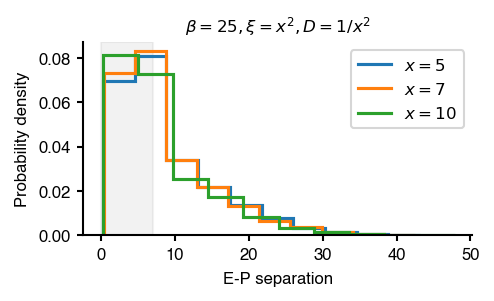

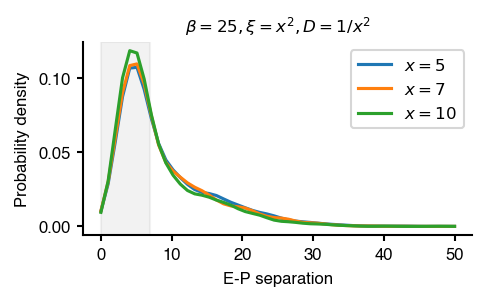

In [ ]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
hist(ax,perturb_FD_B25[0].distance,label=r"$x=25$")
hist(ax,perturb_FD_B25[1].distance,label=r"$x=50$")
hist(ax,perturb_FD_B25[2].distance,label=r"$x=100$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\beta=25,\xi=x, D=1/x$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,perturb_FD_B25[0].distance_g(r),label=r"$x=25$")
ax.plot(r,perturb_FD_B25[1].distance_g(r),label=r"$x=50$")
ax.plot(r,perturb_FD_B25[2].distance_g(r),label=r"$x=100$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\beta=25,\xi=x, D=1/x$")

In [ ]:
"""Finite flow decrease diffusivity only."""
perturb_D_B10 = [Simulation(B=10,F=1,D=n,L=150,directory="old_simulations") for n in [1/25, 1/50, 1/100, 0]]
perturb_D_B25 = [Simulation(B=25,F=1,D=n,L=150,directory="old_simulations") for n in [1/25, 1/50, 1/100, 0]]

simulations/B10_F1_D0.04_L150


Text(0.5, 1.0, '$\\beta=10,\\xi=1$')

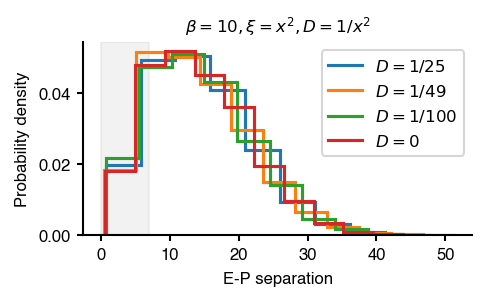

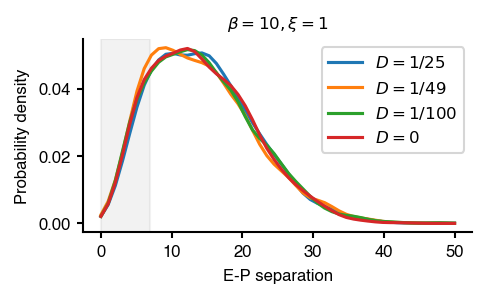

In [ ]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
hist(ax,perturb_D_B10[0].distance,label=r"$D=1/25$")
hist(ax,perturb_D_B10[1].distance,label=r"$D=1/50$")
hist(ax,perturb_D_B10[2].distance,label=r"$D=1/100$")
hist(ax,perturb_D_B10[3].distance,label=r"$D=0$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\beta=10,\xi=x, D=1/x$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
ax.plot(r,perturb_D_B10[0].distance_g(r),label=r"$D=1/25$")
ax.plot(r,perturb_D_B10[1].distance_g(r),label=r"$D=1/50$")
ax.plot(r,perturb_D_B10[2].distance_g(r),label=r"$D=1/100$")
ax.plot(r,perturb_D_B10[3].distance_g(r),label=r"$D=0$")
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.legend()
ax.set_title(r"$\beta=10,\xi=1$")

Text(0.5, 1.0, '$\\beta=25,\\xi=1$')

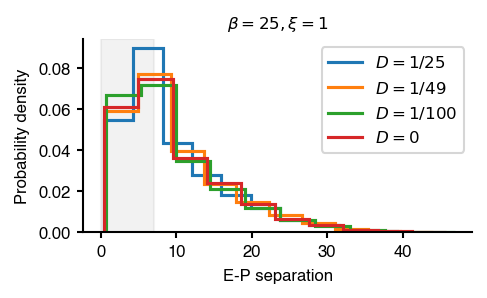

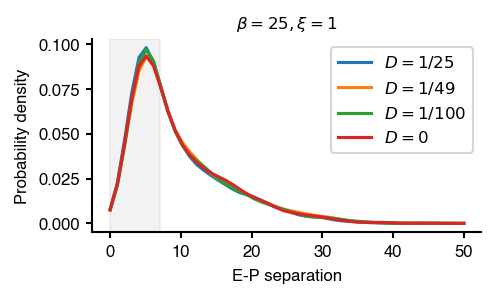

In [ ]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
hist(ax,perturb_D_B25[0].distance,label=r"$D=1/25$")
hist(ax,perturb_D_B25[1].distance,label=r"$D=1/50$")
hist(ax,perturb_D_B25[2].distance,label=r"$D=1/100$")
hist(ax,perturb_D_B25[3].distance,label=r"$D=0$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\beta=25,\xi=1$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
ax.plot(r,perturb_D_B25[0].distance_g(r),label=r"$D=1/25$")
ax.plot(r,perturb_D_B25[1].distance_g(r),label=r"$D=1/50$")
ax.plot(r,perturb_D_B25[2].distance_g(r),label=r"$D=1/100$")
ax.plot(r,perturb_D_B25[3].distance_g(r),label=r"$D=0$")
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.legend()
ax.set_title(r"$\beta=25,\xi=1$")

In [ ]:
"""Finite flow increase friction only."""
perturb_F_B10 = [Simulation(B=10,F=n,D=1,L=150,directory="old_simulations") for n in [25, 50, 100]]
perturb_F_B25 = [Simulation(B=25,F=n,D=1,L=150,directory="old_simulations") for n in [25, 50, 100]]

simulations/B10_F25_D1_L150
simulations/B10_F50_D1_L150
simulations/B10_F100_D1_L150
simulations/B25_F25_D1_L150
simulations/B25_F50_D1_L150
simulations/B25_F100_D1_L150


Text(0.5, 1.0, '$\\beta=0,\\xi=1$')

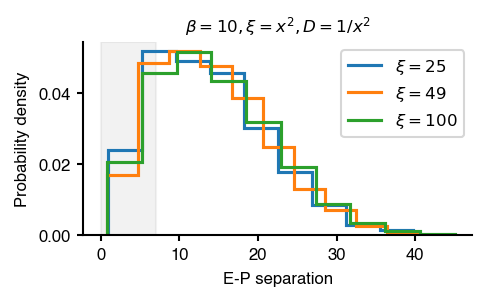

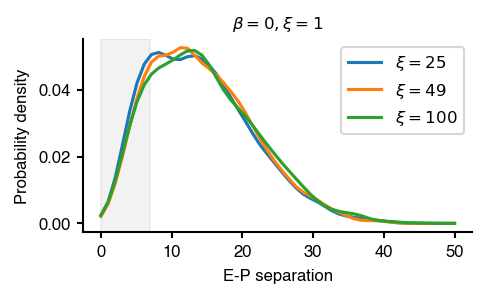

In [ ]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
hist(ax,perturb_F_B10[0].distance,label=r"$\xi=25$")
hist(ax,perturb_F_B10[1].distance,label=r"$\xi=50$")
hist(ax,perturb_F_B10[2].distance,label=r"$\xi=100$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\beta=10,\xi=x, D=1/x$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
ax.plot(r,perturb_F_B10[0].distance_g(r),label=r"$\xi=25$")
ax.plot(r,perturb_F_B10[1].distance_g(r),label=r"$\xi=50$")
ax.plot(r,perturb_F_B10[2].distance_g(r),label=r"$\xi=100$")
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.legend()
ax.set_title(r"$\beta=0,\xi=1$")

Text(0.5, 1.0, '$\\beta=0,\\xi=1$')

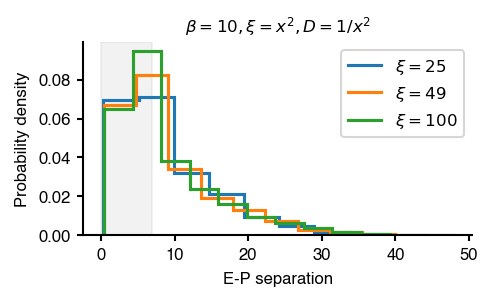

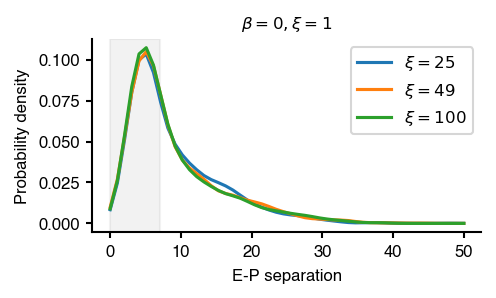

In [ ]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
hist(ax,perturb_F_B25[0].distance,label=r"$\xi=25$")
hist(ax,perturb_F_B25[1].distance,label=r"$\xi=50$")
hist(ax,perturb_F_B25[2].distance,label=r"$\xi=100$")
ax.axvspan(0,7,color="grey",alpha=0.1)
histlegend(ax)
ax.set_title(r"$\beta=10,\xi=x, D=1/x$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
ax.plot(r,perturb_F_B25[0].distance_g(r),label=r"$\xi=25$")
ax.plot(r,perturb_F_B25[1].distance_g(r),label=r"$\xi=50$")
ax.plot(r,perturb_F_B25[2].distance_g(r),label=r"$\xi=100$")
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.legend()
ax.set_title(r"$\beta=0,\xi=1$")